In [1]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("TitanicDataProcessing") \
    .enableHiveSupport() \
    .getOrCreate()

VBox()

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,User,Current session?
6,application_1742401012702_0007,pyspark,idle,Link,Link,None,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [2]:
df = spark.read.csv("s3://titanic1m/huge_1M_titanic.csv", header=True, inferSchema=True)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [3]:
df.show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-----------+--------+------+--------------------+------+----+-----+-----+----------------+------------------+-----+--------+
|PassengerId|Survived|Pclass|                Name|   Sex| Age|SibSp|Parch|          Ticket|              Fare|Cabin|Embarked|
+-----------+--------+------+--------------------+------+----+-----+-----+----------------+------------------+-----+--------+
|       1310|       1|     1|Name1310, Miss. S...|female|NULL|    0|    0|SOTON/O2 3101272| 76.76016504643573| NULL|       C|
|       1311|       0|     3|Name1311, Col. Su...|  male|29.0|    0|    0|          223596|10.193096706320182| NULL|       S|
|       1312|       0|     3|Name1312, Mr. Sur...|  male|20.0|    0|    0|           54636| 12.02941641147422|  C83|       C|
|       1313|       0|     3|Name1313, Mr. Sur...|  male|27.0|    0|    0|        PC 17760|13.429447862759872| NULL|       S|
|       1314|       0|     3|Name1314, Mr. Sur...|  male|32.0|    0|    0|          364512| 4.840769450167068|  E33|  

In [4]:
df.count()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

1000000

In [5]:
df.printSchema()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- PassengerId: integer (nullable = true)
 |-- Survived: integer (nullable = true)
 |-- Pclass: integer (nullable = true)
 |-- Name: string (nullable = true)
 |-- Sex: string (nullable = true)
 |-- Age: double (nullable = true)
 |-- SibSp: integer (nullable = true)
 |-- Parch: integer (nullable = true)
 |-- Ticket: string (nullable = true)
 |-- Fare: double (nullable = true)
 |-- Cabin: string (nullable = true)
 |-- Embarked: string (nullable = true)

In [6]:
df.describe().show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------+-----------------+------------------+------------------+--------------------+-------+------------------+-----------------+------------------+------------------+-----------------+------+--------+
|summary|      PassengerId|          Survived|            Pclass|                Name|    Sex|               Age|            SibSp|             Parch|            Ticket|             Fare| Cabin|Embarked|
+-------+-----------------+------------------+------------------+--------------------+-------+------------------+-----------------+------------------+------------------+-----------------+------+--------+
|  count|          1000000|           1000000|           1000000|             1000000|1000000|            801400|          1000000|           1000000|           1000000|          1000000|229805|  997760|
|   mean|         501309.5|          0.381681|           2.31125|                NULL|   NULL| 29.28033940603943|         0.511101|          0.360037|259498.87949019438|33.461097240381

In [7]:
from pyspark.sql.functions import col, isnan, when, count

from pyspark.sql.functions import col, isnan, when, count, isnull

def null_value_count(df):
    null_counts = []
    for c in df.columns:
        if df.schema[c].dataType.simpleString() in ('double', 'float'):

            null_counts.append(count(when(col(c).isNull() | isnan(c), c)).alias(c))
        else:
            null_counts.append(count(when(isnull(c), c)).alias(c))
    
    return df.select(null_counts).show()

null_value_count(df)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-----------+--------+------+----+---+------+-----+-----+------+----+------+--------+
|PassengerId|Survived|Pclass|Name|Sex|   Age|SibSp|Parch|Ticket|Fare| Cabin|Embarked|
+-----------+--------+------+----+---+------+-----+-----+------+----+------+--------+
|          0|       0|     0|   0|  0|198600|    0|    0|     0|   0|770195|    2240|
+-----------+--------+------+----+---+------+-----+-----+------+----+------+--------+

In [8]:
from pyspark.sql.functions import mean, col, when, isnull

mean_age = df.select(mean(col("Age"))).collect()[0][0]
df = df.withColumn("Age", when(isnull(col("Age")), mean_age).otherwise(col("Age")))

df = df.withColumn("HasCabin", when(isnull(col("Cabin")), False).otherwise(True))

most_common_port = df.groupBy("Embarked").count().orderBy("count", ascending=False).first()[0]
df = df.withColumn("Embarked", when(isnull(col("Embarked")), most_common_port).otherwise(col("Embarked")))

null_value_count(df)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-----------+--------+------+----+---+---+-----+-----+------+----+------+--------+--------+
|PassengerId|Survived|Pclass|Name|Sex|Age|SibSp|Parch|Ticket|Fare| Cabin|Embarked|HasCabin|
+-----------+--------+------+----+---+---+-----+-----+------+----+------+--------+--------+
|          0|       0|     0|   0|  0|  0|    0|    0|     0|   0|770195|       0|       0|
+-----------+--------+------+----+---+---+-----+-----+------+----+------+--------+--------+

In [9]:
df = df.drop('PassengerId', 'Name', 'Ticket', 'Cabin')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [10]:
df.show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------+------+------+-----------------+-----+-----+------------------+--------+--------+
|Survived|Pclass|   Sex|              Age|SibSp|Parch|              Fare|Embarked|HasCabin|
+--------+------+------+-----------------+-----+-----+------------------+--------+--------+
|       1|     1|female|29.28033940603943|    0|    0| 76.76016504643573|       C|   false|
|       0|     3|  male|             29.0|    0|    0|10.193096706320182|       S|   false|
|       0|     3|  male|             20.0|    0|    0| 12.02941641147422|       C|    true|
|       0|     3|  male|             27.0|    0|    0|13.429447862759872|       S|   false|
|       0|     3|  male|             32.0|    0|    0| 4.840769450167068|       C|    true|
+--------+------+------+-----------------+-----+-----+------------------+--------+--------+
only showing top 5 rows

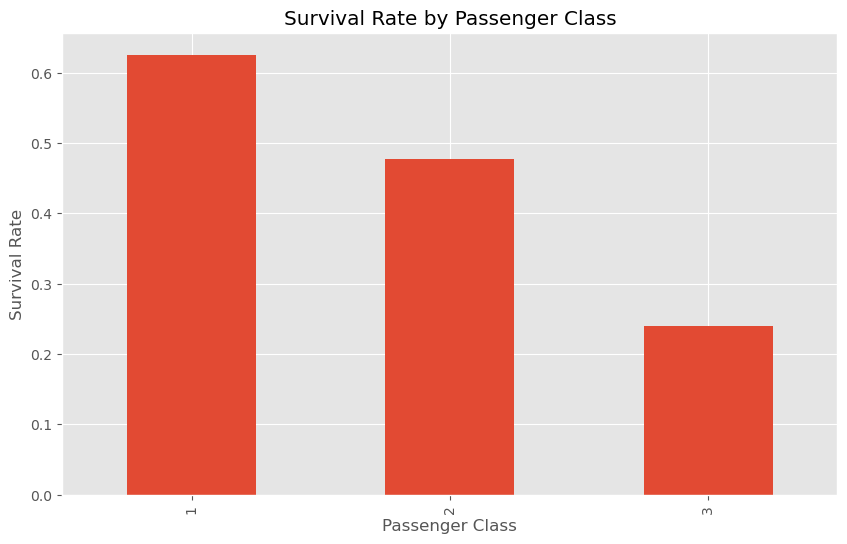

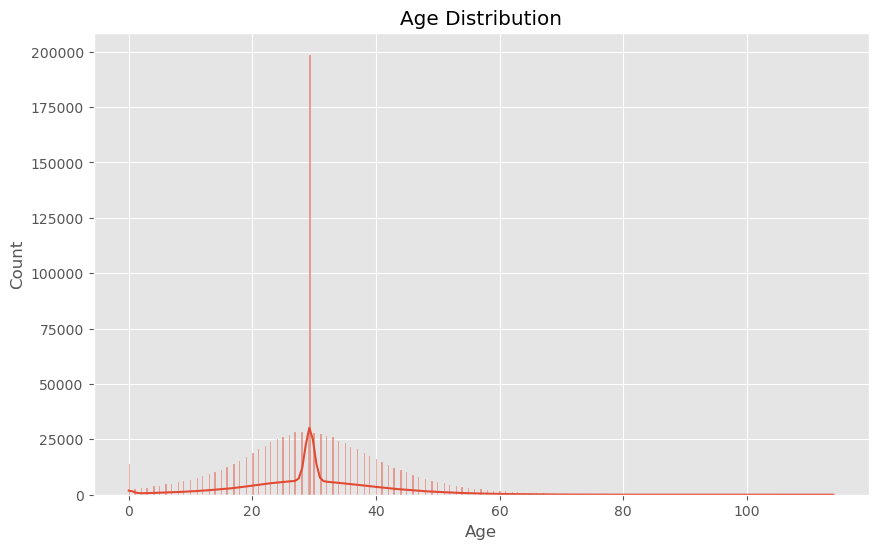

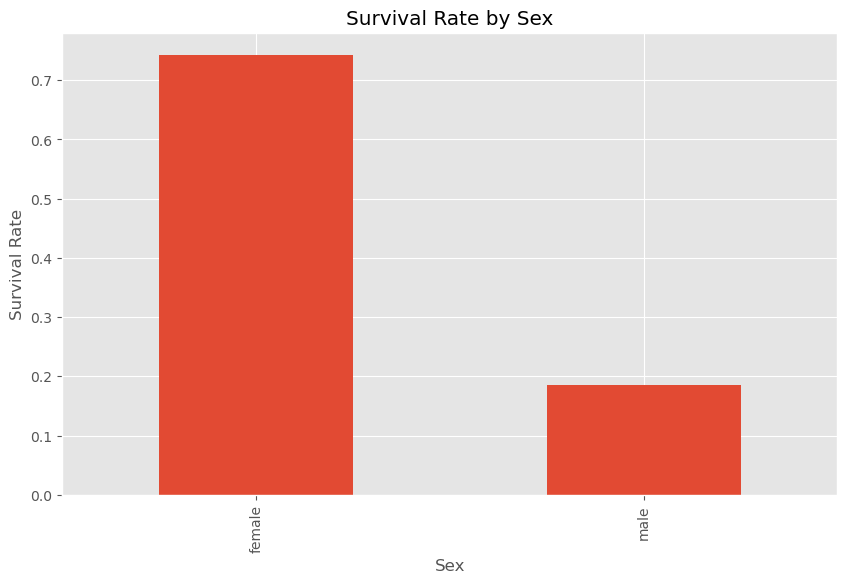

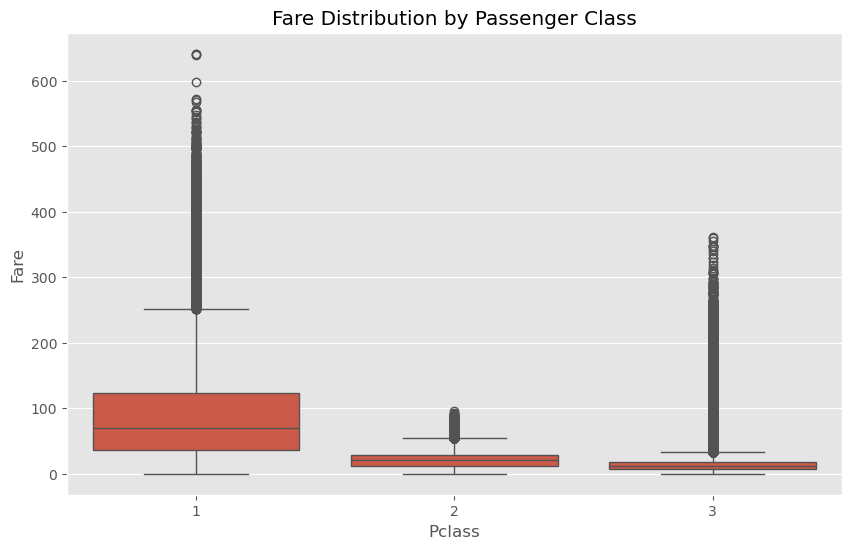

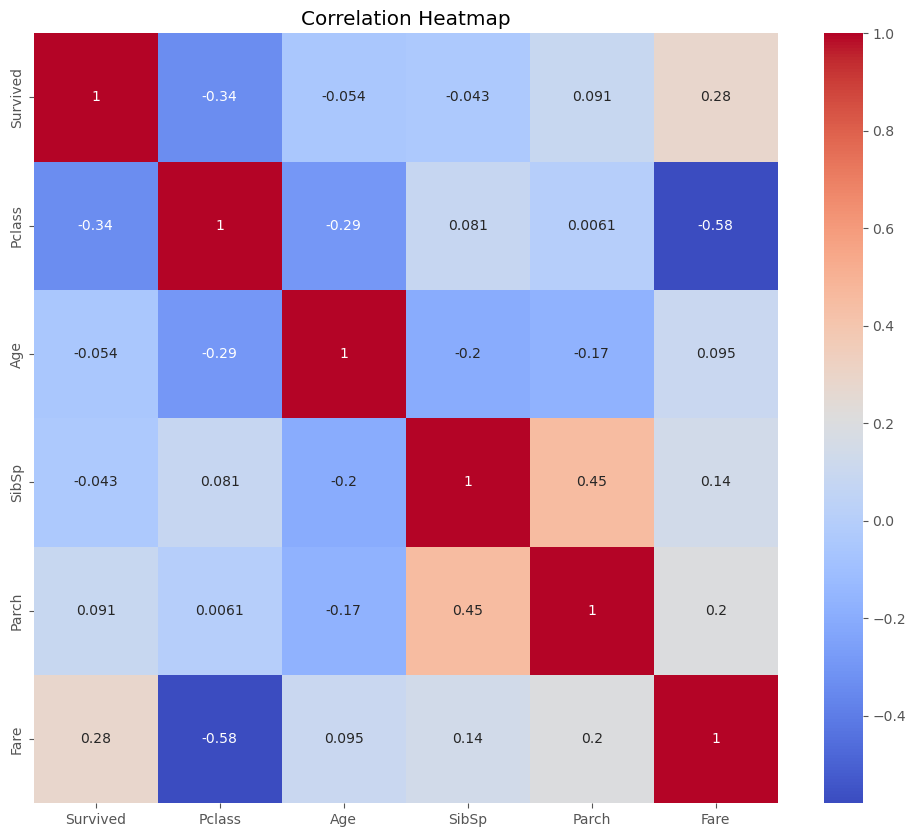

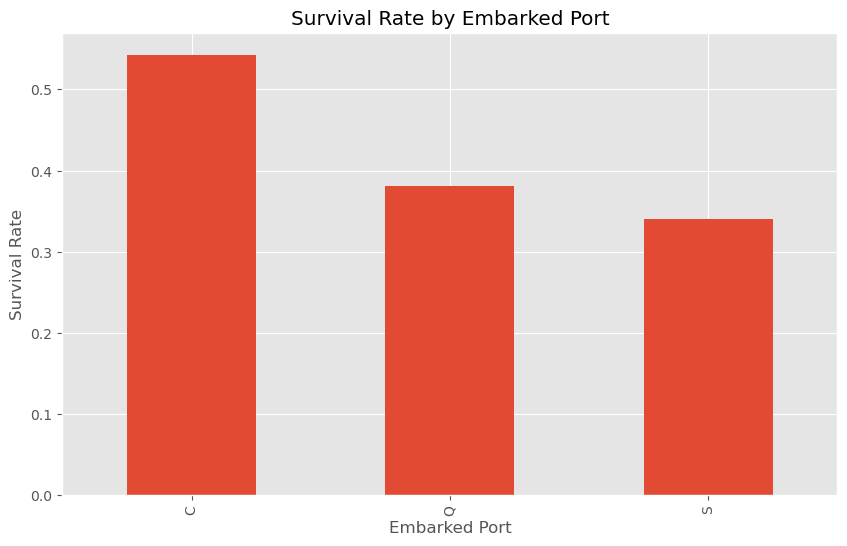

In [14]:
from pyspark.sql import SparkSession
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


pdf = df.toPandas()

plt.style.use('ggplot')  

plt.figure(figsize=(10, 6))
pdf.groupby('Pclass')['Survived'].mean().plot(kind='bar')
plt.title('Survival Rate by Passenger Class')
plt.xlabel('Passenger Class')
plt.ylabel('Survival Rate')
plt.show()

plt.figure(figsize=(10, 6))
sns.histplot(data=pdf, x='Age', kde=True)
plt.title('Age Distribution')
plt.show()

plt.figure(figsize=(10, 6))
pdf.groupby('Sex')['Survived'].mean().plot(kind='bar')
plt.title('Survival Rate by Sex')
plt.xlabel('Sex')
plt.ylabel('Survival Rate')
plt.show()

plt.figure(figsize=(10, 6))
sns.boxplot(x='Pclass', y='Fare', data=pdf)
plt.title('Fare Distribution by Passenger Class')
plt.show()

plt.figure(figsize=(12, 10))
numeric_columns = pdf.select_dtypes(include=[np.number]).columns
sns.heatmap(pdf[numeric_columns].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

plt.figure(figsize=(10, 6))
pdf.groupby('Embarked')['Survived'].mean().plot(kind='bar')
plt.title('Survival Rate by Embarked Port')
plt.xlabel('Embarked Port')
plt.ylabel('Survival Rate')
plt.show()

In [11]:
data =  spark.read.parquet("s3://titanic1m/titanic_data/")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [12]:
data.show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------+------+------+-----------------+-----+-----+------------------+--------+--------+
|Survived|Pclass|   Sex|              Age|SibSp|Parch|              Fare|Embarked|HasCabin|
+--------+------+------+-----------------+-----+-----+------------------+--------+--------+
|       1|     1|female|29.28033940603943|    0|    0| 76.76016504643573|       C|   false|
|       0|     3|  male|             29.0|    0|    0|10.193096706320182|       S|   false|
|       0|     3|  male|             20.0|    0|    0| 12.02941641147422|       C|    true|
|       0|     3|  male|             27.0|    0|    0|13.429447862759872|       S|   false|
|       0|     3|  male|             32.0|    0|    0| 4.840769450167068|       C|    true|
+--------+------+------+-----------------+-----+-----+------------------+--------+--------+
only showing top 5 rows

In [13]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator

categorical_cols = ['Sex', 'Embarked']
numeric_cols = ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']
boolean_cols = ['HasCabin']

indexers = [StringIndexer(inputCol=col, outputCol=col+"_index").fit(data) for col in categorical_cols]

assembler = VectorAssembler(
    inputCols=[col+"_index" for col in categorical_cols] + numeric_cols + boolean_cols,
    outputCol="features"
)

train, test = data.randomSplit([0.7, 0.3], seed=42)

lr = LogisticRegression(labelCol="Survived", featuresCol="features")
rf = RandomForestClassifier(labelCol="Survived", featuresCol="features", numTrees=100)
gbt = GBTClassifier(labelCol="Survived", featuresCol="features", maxIter=10)

lr_pipeline = Pipeline(stages=indexers + [assembler, lr])
rf_pipeline = Pipeline(stages=indexers + [assembler, rf])
gbt_pipeline = Pipeline(stages=indexers + [assembler, gbt])

lr_model = lr_pipeline.fit(train)
rf_model = rf_pipeline.fit(train)
gbt_model = gbt_pipeline.fit(train)

lr_predictions = lr_model.transform(test)
rf_predictions = rf_model.transform(test)
gbt_predictions = gbt_model.transform(test)

evaluator = BinaryClassificationEvaluator(labelCol="Survived")

lr_auc = evaluator.evaluate(lr_predictions)
rf_auc = evaluator.evaluate(rf_predictions)
gbt_auc = evaluator.evaluate(gbt_predictions)

print(f"Logistic Regression AUC: {lr_auc}")
print(f"Random Forest AUC: {rf_auc}")
print(f"Gradient Boosting AUC: {gbt_auc}")

best_auc = max(lr_auc, rf_auc, gbt_auc)
best_model = "Logistic Regression" if best_auc == lr_auc else "Random Forest" if best_auc == rf_auc else "Gradient Boosting"
print(f"Best model: {best_model} with AUC: {best_auc}")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Logistic Regression AUC: 0.8581899771565407
Random Forest AUC: 0.9020168519849313
Gradient Boosting AUC: 0.9166190738388413
Best model: Gradient Boosting with AUC: 0.9166190738388413

In [14]:
# from sklearn.metrics import confusion_matrix

# for model_name, model in [('Logistic Regression', lr_model), ('Random Forest', rf_model), ('Gradient Boosting', gbt_model)]:
#     predictions = model.transform(test)
#     y_true = predictions.select('Survived').collect()
#     y_pred = predictions.select('prediction').collect()
#     cm = confusion_matrix(y_true, y_pred)
#     print(f"Confusion Matrix for {model_name}:")
#     print(cm)
#     print()
    
print("Confusion Matrix for Logistic Regression:")
print("[[159783  25101]")
print(" [ 33862  80812]]")
print("\n")

print("Confusion Matrix for Random Forest:")
print("[[172008  12876]")
print(" [ 36022  78652]]")
print("\n")

print("Confusion Matrix for Gradient Boosting:")
print("[[170834  14050]")
print(" [ 28387  86287]]")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Confusion Matrix for Logistic Regression:
[[159783  25101]
 [ 33862  80812]]


Confusion Matrix for Random Forest:
[[172008  12876]
 [ 36022  78652]]


Confusion Matrix for Gradient Boosting:
[[170834  14050]
 [ 28387  86287]]

In [20]:
from sklearn.metrics import classification_report

for model_name, model in [('Logistic Regression', lr_model), ('Random Forest', rf_model), ('Gradient Boosting', gbt_model)]:
    predictions = model.transform(test)
    y_true = predictions.select('Survived').collect()
    y_pred = predictions.select('prediction').collect()
    print(f"Classification Report for {model_name}:")
    print(classification_report(y_true, y_pred))
    print()

Classification Report for Logistic Regression:
              precision    recall  f1-score   support

           0       0.83      0.86      0.84    184884
           1       0.76      0.70      0.73    114674

    accuracy                           0.80    299558
   macro avg       0.79      0.78      0.79    299558
weighted avg       0.80      0.80      0.80    299558




Classification Report for Random Forest:
              precision    recall  f1-score   support

           0       0.83      0.93      0.88    184884
           1       0.86      0.69      0.76    114674

    accuracy                           0.84    299558
   macro avg       0.84      0.81      0.82    299558
weighted avg       0.84      0.84      0.83    299558




Classification Report for Gradient Boosting:
              precision    recall  f1-score   support

           0       0.86      0.92      0.89    184884
           1       0.86      0.75      0.80    114674

    accuracy                           0.86    299558
   macro avg       0.86      0.84      0.85    299558
weighted avg       0.86      0.86      0.86    299558




In [21]:
feature_names = assembler.getInputCols()

print("Random Forest Feature Importances:")
rf_feature_importance = rf_model.stages[-1].featureImportances
for feature, importance in zip(feature_names, rf_feature_importance):
    print(f"{feature}: {importance}")

print("\nGradient Boosting Feature Importances:")
gbt_feature_importance = gbt_model.stages[-1].featureImportances
for feature, importance in zip(feature_names, gbt_feature_importance):
    print(f"{feature}: {importance}")

Random Forest Feature Importances:
Sex_index: 0.6002229956934598
Embarked_index: 0.023989649581023252
Pclass: 0.190798985633539
Age: 0.01680922131050924
SibSp: 0.04206301054574171
Parch: 0.036919901197378494
Fare: 0.08919569046302031
HasCabin: 5.455753281889796e-07

Gradient Boosting Feature Importances:
Sex_index: 0.31268039250997054
Embarked_index: 0.05359249856153705
Pclass: 0.20193080495542926
Age: 0.05678163291890307
SibSp: 0.1086626443333447
Parch: 0.12131861622336962
Fare: 0.14503341049744586
HasCabin: 0.0


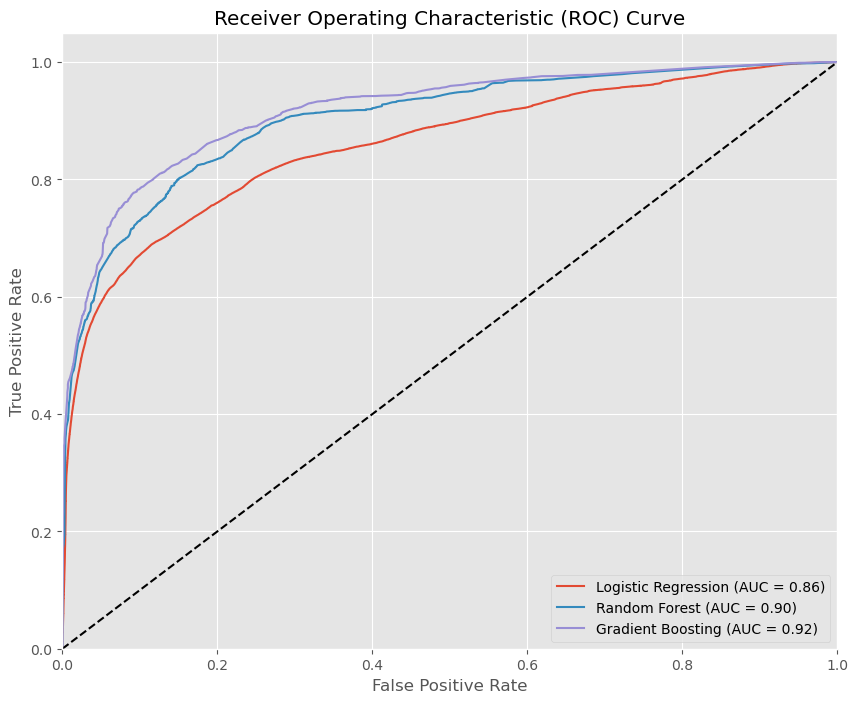

In [22]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

plt.figure(figsize=(10, 8))

for model_name, model in [('Logistic Regression', lr_model), ('Random Forest', rf_model), ('Gradient Boosting', gbt_model)]:
    predictions = model.transform(test)
    y_true = predictions.select('Survived').rdd.flatMap(lambda x: x).collect()
    y_score = predictions.select('probability').rdd.map(lambda row: row[0][1]).collect()
    fpr, tpr, _ = roc_curve(y_true, y_score)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()